
Python was not able to load the fast fortran material routines.


*************************************************************
Loading gmsh-mesh from H:\TUM-PC\Dokumente\Projects\AMfe\meshes/test_meshes/1_rectangle_8_elem.msh
Mesh H:\TUM-PC\Dokumente\Projects\AMfe\meshes/test_meshes/1_rectangle_8_elem.msh successfully imported. 
Assign a material to a physical group.
*************************************************************


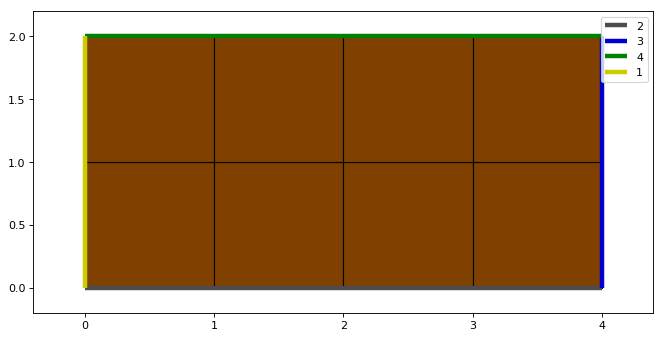


*************************************************************
Loading gmsh-mesh from H:\TUM-PC\Dokumente\Projects\AMfe\meshes/test_meshes/1_rectangle_2_elem.msh
Mesh H:\TUM-PC\Dokumente\Projects\AMfe\meshes/test_meshes/1_rectangle_2_elem.msh successfully imported. 
Assign a material to a physical group.
*************************************************************


In [1]:
# importing lib and setting a list of meshes to be tested
import sys 
import amfe
import matplotlib.pyplot as plt
import numpy as np
import scipy
import copy
import pandas as pd

msh_dict = {}
msh_dict[0] = amfe.amfe_dir('meshes/test_meshes/1_rectangle_8_elem.msh')
msh_dict[1] = mshfile = amfe.amfe_dir('meshes/test_meshes/1_rectangle_2_elem.msh')



domain_id = {}
domain_id[0] = 6
domain_id[1] = 6

# select mesh to be plotted
mesh_id1 = 0
mshfile = msh_dict[mesh_id1]

m1 = amfe.Mesh()
m1.import_msh(mshfile)

fig, ax1=plt.subplots(1,figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
amfe.plot_mesh(m1,ax1)
plt.show()

# select mesh to be plotted
mesh_id1 = 1
mshfile = msh_dict[mesh_id1]

m2 = amfe.Mesh()
m2.import_msh(mshfile)

m3 = m2.translation([2,0,0])

# creating material
my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=0.1)

# append domains to MechanicalAssembly
my_system = amfe.MechanicalAssembly()

submesh1 = m2.set_domain('phys_group',domain_id[1])
submesh2 = m3.set_domain('phys_group',domain_id[1])

my_system.append_domain(submesh1, my_material, 1)
my_system.append_domain(submesh2, my_material, 2)
my_system.update_global_system()


# select submesh for interfaces
sub_int1 = my_system.get_submesh(1,3)
sub_int2 = my_system.get_submesh(2,1)
my_system.add_bonded_interface_constraint(sub_int1,sub_int2)
my_system.update_global_system()

# replacing phys tags to avoid conflict
my_system.change_domain_physical_tag(2,1,5)
my_system.change_domain_physical_tag(1,3,7)
my_system.update_global_system()


# mesh of one turbine section
m4 = my_system.get_global_mesh()

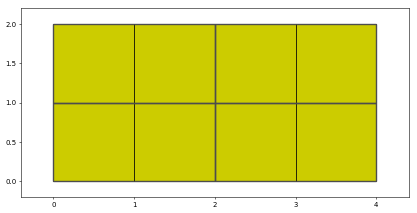

In [2]:
# mesh of one turbine section
m5 = m4.translation([0,1,0])

submesh4 = m4.set_domain('phys_group',domain_id[1])
submesh5 = m5.set_domain('phys_group',domain_id[1])

global_system = amfe.MechanicalAssembly()
global_system.append_domain(submesh4, my_material, 1)
global_system.append_domain(submesh5, my_material, 2)
global_system.update_global_system()

# select submesh for interfaces
sub_int1 = global_system.get_submesh(1,4)
sub_int2 = global_system.get_submesh(2,2)
global_system.add_bonded_interface_constraint(sub_int1,sub_int2)
global_system.update_global_system()

new_mesh2 = global_system.get_global_mesh()
fig, ax1=plt.subplots(1,figsize=(10, 5), dpi= 50, facecolor='w', edgecolor='k')
amfe.plot_mesh(new_mesh2,ax1,False)
plt.show()

In [3]:
# select submesh for Neumann B.C
sub_neu1 = global_system.get_submesh(2,3)
sub_neu2 = global_system.get_submesh(1,3)

# select submesh for Dirichlet
sub_dir1 = global_system.get_submesh(1,1)
sub_dir2 = global_system.get_submesh(2,1)

value = 1.0e8
global_system.apply_neumann_boundaries(sub_neu1,value)
global_system.apply_neumann_boundaries(sub_neu2,value)
global_system.apply_dirichlet_boundaries(sub_dir1,0.0,'xy')
global_system.apply_dirichlet_boundaries(sub_dir2,0.0,'xy')

global_system.update_domain()


Preallocating the stiffness matrix
Done preallocating stiffness matrix with 8 elements and 30 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 16 elements and 30 dofs.
Time taken for preallocation: 0.00 seconds.


In [4]:
domain = global_system
domain.split_in_partitions()

super_domain = amfe.SuperDomain(domain.groups)
B = super_domain.assemble_global_B()
Kd, fd = super_domain.assemble_block_stiffness_and_force()
G, e = super_domain.assemble_global_G_and_e()
F, d = super_domain.assemble_F_and_d()

n_null = len(e) # null space size
n_int = len(d) # interface size
Zeros = np.zeros([n_null ,n_null])

A1 = np.hstack((F,G.T))
A2 = np.hstack((G,Zeros))

A = np.vstack((A1,A2))
b = np.concatenate((d,e))

# # Dual interface problem
# x = np.linalg.solve(A,b)
# global_lambda = x[:n_int]
# alpha = x[n_int:]

# global_alpha = alpha

# u = super_domain.eval_subdomain_displacement(global_lambda,alpha)

Extract interface node from sub_1 and sub_2
Extract interface node from sub_1 and sub_3
Extract interface node from sub_1 and sub_4
Interface nodes from sub_2 and sub_1 already extracted
Extract interface node from sub_2 and sub_3
Extract interface node from sub_2 and sub_4
Interface nodes from sub_3 and sub_1 already extracted
Interface nodes from sub_3 and sub_2 already extracted
Extract interface node from sub_3 and sub_4
Interface nodes from sub_4 and sub_1 already extracted
Interface nodes from sub_4 and sub_2 already extracted
Interface nodes from sub_4 and sub_3 already extracted
Extract interface node from sub_1 and sub_2
Extract interface node from sub_1 and sub_3
Extract interface node from sub_1 and sub_4
Interface nodes from sub_2 and sub_1 already extracted
Extract interface node from sub_2 and sub_3
Extract interface node from sub_2 and sub_4
Interface nodes from sub_3 and sub_1 already extracted
Interface nodes from sub_3 and sub_2 already extracted
Extract interface nod

C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\py36\Lib\site-packages\scipy\sparse\compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [5]:
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets

# def plot_static(scale=0):
#     connectivity = {}
#     nodes = {}
#     fig, ax1=plt.subplots(1,figsize=(10, 5), dpi= 50, facecolor='w', edgecolor='k')
#     for sub_key in super_domain.domains_key_list:
#         sub = super_domain.get_feti_subdomains(sub_key)
#         connectivity[sub_key] = sub.mesh.connectivity
#         nodes[sub_key] = sub.mesh.nodes
#         quad, ax = amfe.plotDeformQuadMesh(connectivity[sub_key],nodes[sub_key],u[sub_key],scale,ax1) 
          
#     plt.show()

# interact(plot_static,scale=(0,200,5))  

In [6]:
# solving the project Dual interface problem
I = np.eye(n_int,n_int)
GGT =  G.dot(G.T)
GTe = G.T.dot(e)
P = I - G.T.dot(np.linalg.inv(GGT)).dot(G)

# Solving lamda im
lambda_im = G.T.dot(np.linalg.solve(GGT,e))

In [7]:
r0 = d - F.dot(lambda_im)
n_int = len(r0)

GGT_inv = np.linalg.inv(GGT)
F_action = lambda x : F.dot(x)
P_action = lambda w : (np.eye(n_int) - G.T.dot(GGT_inv).dot(G)).dot(w)

lambda_ker, last_res, proj_r_hist, lambda_hist = amfe.PCGP(F_action,r0,P_action)
lambda_sol =  lambda_im + lambda_ker

dtil = d - F_action(lambda_sol)
alpha_pgc = np.linalg.solve(GGT,G.dot(dtil))
u = super_domain.eval_subdomain_displacement(lambda_sol,0*alpha_pgc)

In [8]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
def plot_static(scale=0,alpha_scale=1):
    u = super_domain.eval_subdomain_displacement(lambda_sol,alpha_scale*alpha_pgc)
    connectivity = {}
    nodes = {}
    fig, ax1=plt.subplots(1,figsize=(10, 5), dpi= 50, facecolor='w', edgecolor='k')
    for sub_key in super_domain.domains_key_list:
        sub = super_domain.get_feti_subdomains(sub_key)
        connectivity[sub_key] = sub.mesh.connectivity
        nodes[sub_key] = sub.mesh.nodes
        quad, ax = amfe.plotDeformQuadMesh(connectivity[sub_key],nodes[sub_key],u[sub_key],scale,ax1) 
          
    plt.show()
    return u

u = interact(plot_static,scale=(0,200,5),alpha_scale=(-1,1,0.1))  

A Jupyter Widget

In [9]:
lambda_ker

array([ -1.48855021e+07,  -1.34400459e+06,   7.44275104e+06,
        -1.44740154e+06,   1.28152627e-03,   5.29262835e+05,
        -2.46272526e-08,   4.61014111e-09,   7.13427916e-04,
        -6.03480978e+06,   7.44275104e+06,   1.97666438e+06,
        -7.44275104e+06,   1.97666438e+06,  -5.74968365e-06,
        -6.69336565e+06,   4.07994484e-06,   3.42406592e+06,
        -2.41634364e-06,  -1.49877078e+06,   7.44275104e+06,
         1.44740154e+06,  -1.48855021e+07,   1.34400459e+06])

In [10]:
lambda_sol

array([ -4.98855021e+07,   3.22662072e+05,  -2.50572490e+07,
         2.19265126e+05,   1.28152627e-03,   5.29262835e+05,
        -2.46272526e-08,   4.61014111e-09,   7.13427916e-04,
        -6.03480978e+06,  -2.50572490e+07,   3.09997709e+05,
         2.50572490e+07,   3.09997709e+05,  -5.76060130e-06,
        -2.66989824e+04,   4.09510422e-06,   9.07325830e+04,
        -2.37950940e-06,   1.67895889e+05,  -2.50572490e+07,
        -2.19265126e+05,  -4.98855021e+07,  -3.22662072e+05])

In [11]:
d

array([  2.12428027e-03,  -1.97829132e-04,   2.12428027e-03,
         1.97829132e-04,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   2.12428027e-03,  -1.97829132e-04,
        -2.12428027e-03,  -1.97829132e-04,   4.64905892e-16,
        -1.03291317e-03,   2.98502542e-15,  -3.95658263e-04,
         1.72404408e-15,  -7.14285714e-04,   2.12428027e-03,
        -1.97829132e-04,   2.12428027e-03,   1.97829132e-04])

In [12]:
F_action(lambda_sol)

array([ -1.19652620e-02,  -9.23220552e-04,  -1.19712845e-02,
        -5.27562289e-04,   1.67055952e-12,   1.06646029e-13,
         1.41096397e-20,   7.44302661e-21,   9.29535962e-13,
         3.60382297e-14,  -1.19712845e-02,   5.27562287e-04,
         1.19712845e-02,   5.27562289e-04,  -5.00391829e-15,
         3.93779517e-04,   2.10291853e-15,   1.05512458e-03,
        -2.18332568e-15,   7.24452046e-04,  -1.19712845e-02,
         5.27562286e-04,  -1.19652620e-02,   9.23220550e-04])

In [13]:
lambda_im

array([ -3.50000000e+07,   1.66666667e+06,  -3.25000000e+07,
         1.66666667e+06,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -3.25000000e+07,  -1.66666667e+06,
         3.25000000e+07,  -1.66666667e+06,  -1.09176493e-08,
         6.66666667e+06,   1.51593828e-08,  -3.33333333e+06,
         3.68342389e-08,   1.66666667e+06,  -3.25000000e+07,
        -1.66666667e+06,  -3.50000000e+07,  -1.66666667e+06])

In [14]:
lambda_sol

array([ -4.98855021e+07,   3.22662072e+05,  -2.50572490e+07,
         2.19265126e+05,   1.28152627e-03,   5.29262835e+05,
        -2.46272526e-08,   4.61014111e-09,   7.13427916e-04,
        -6.03480978e+06,  -2.50572490e+07,   3.09997709e+05,
         2.50572490e+07,   3.09997709e+05,  -5.76060130e-06,
        -2.66989824e+04,   4.09510422e-06,   9.07325830e+04,
        -2.37950940e-06,   1.67895889e+05,  -2.50572490e+07,
        -2.19265126e+05,  -4.98855021e+07,  -3.22662072e+05])

In [15]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
def plot_static(scale=200,alpha_0=0,
                          alpha_1=0,
                          alpha_2=0,
                          alpha_3=0,
                          alpha_4=0,
                          alpha_5=0):
    alpha_vec = np.array([alpha_0,alpha_1,alpha_2,alpha_3,alpha_4,alpha_5])
    u = super_domain.eval_subdomain_displacement(lambda_sol,alpha_vec,method='cholsps')
    connectivity = {}
    nodes = {}
    fig, ax1=plt.subplots(1,figsize=(10, 5), dpi= 50, facecolor='w', edgecolor='k')
    for sub_key in super_domain.domains_key_list:
        sub = super_domain.get_feti_subdomains(sub_key)
        connectivity[sub_key] = sub.mesh.connectivity
        nodes[sub_key] = sub.mesh.nodes
        quad, ax = amfe.plotDeformQuadMesh(connectivity[sub_key],nodes[sub_key],u[sub_key],scale,ax1) 
    
    plt.xlim([-4,8])
    plt.ylim([-1,3])
    plt.show()

    return None

u0 = interact(plot_static,scale=(0,200,5),alpha_0=(-1,1,0.1),alpha_1=(-1,1,0.1),alpha_2=(-1,1,0.1),alpha_3=(-1,1,0.1),
              alpha_4=(-1,1,0.1),alpha_5=(-1,1,0.1))  


A Jupyter Widget

In [16]:
lambda_sol


array([ -4.98855021e+07,   3.22662072e+05,  -2.50572490e+07,
         2.19265126e+05,   1.28152627e-03,   5.29262835e+05,
        -2.46272526e-08,   4.61014111e-09,   7.13427916e-04,
        -6.03480978e+06,  -2.50572490e+07,   3.09997709e+05,
         2.50572490e+07,   3.09997709e+05,  -5.76060130e-06,
        -2.66989824e+04,   4.09510422e-06,   9.07325830e+04,
        -2.37950940e-06,   1.67895889e+05,  -2.50572490e+07,
        -2.19265126e+05,  -4.98855021e+07,  -3.22662072e+05])

In [17]:
super_domain.lambda_global_dict

{(1, 2): array([0, 1, 2, 3]),
 (1, 3): array([4, 5, 6, 7, 8, 9]),
 (1, 4): array([10, 11]),
 (2, 1): array([0, 1, 2, 3]),
 (2, 3): array([12, 13]),
 (2, 4): array([14, 15, 16, 17, 18, 19]),
 (3, 1): array([4, 5, 6, 7, 8, 9]),
 (3, 2): array([12, 13]),
 (3, 4): array([20, 21, 22, 23]),
 (4, 1): array([10, 11]),
 (4, 2): array([14, 15, 16, 17, 18, 19]),
 (4, 3): array([20, 21, 22, 23])}

In [18]:
alpha_pgc

array([ 0.02168726,  0.01449937,  0.02267458,  0.02200225,  0.00196841,
       -0.02658443])

In [19]:
G

array([[ 0.39181781, -0.4456824 ,  0.14127243, -0.4456824 , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.14127243,  0.4456824 , -0.14127243,
        -0.05540836, -0.14127243,  0.4456824 , -0.14127243,  0.19513702,
        -0.        , -0.        , -0.        , -0.        ],
       [ 0.00728577,  0.18426044,  0.35175628,  0.18426044, -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.35175628, -0.18426044, -0.35175628,
         0.50468057, -0.35175628, -0.18426044, -0.35175628,  0.16021007,
        -0.        , -0.        , -0.        , -0.        ],
       [ 0.24196473,  0.34044109,  0.26159288,  0.34044109, -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.26159288, -0.34044109, -0.26159288,
        -0.30118479, -0.26159288, -0.34044109, -0.26159288, -0.32081294,
  

In [20]:
e

array([-26654512.36982586, -17952102.56915239, -25177880.17963583,
       -27400528.83198825,  -3132073.52675244,  30100960.14776047])

In [22]:
d

array([  2.12428027e-03,  -1.97829132e-04,   2.12428027e-03,
         1.97829132e-04,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   2.12428027e-03,  -1.97829132e-04,
        -2.12428027e-03,  -1.97829132e-04,   4.64905892e-16,
        -1.03291317e-03,   2.98502542e-15,  -3.95658263e-04,
         1.72404408e-15,  -7.14285714e-04,   2.12428027e-03,
        -1.97829132e-04,   2.12428027e-03,   1.97829132e-04])